In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

C:\Users\praveen ji\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Utils

In [214]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 55))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

In [72]:
dfz= pd.read_csv('Adj_close.csv')

In [73]:
print('shape',dfz.shape)
print('head \n',dfz.head(2))

shape (1081, 5)
head 
       S          T   TMUS         VZ        date
0  7.99  28.200116  26.61  41.839149  2018-03-27
1  7.98  27.964370  26.26  41.400247  2018-03-26


In [74]:
dfz['close_change'] = dfz.S.pct_change()
dfz['log_ret'] = np.log(dfz.S) - np.log(dfz.S.shift(1))

In [75]:
print('shape',dfz.shape)
print('head \n',dfz.head(2))

shape (1081, 7)
head 
       S          T   TMUS         VZ        date  close_change   log_ret
0  7.99  28.200116  26.61  41.839149  2018-03-27           NaN       NaN
1  7.98  27.964370  26.26  41.400247  2018-03-26     -0.001252 -0.001252


In [76]:
scaler = MinMaxScaler()
x_dfz_train = np.array([scaler.fit_transform(dfz['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(dfz['log_ret'])))])
x_dfz_train = x_dfz_train.squeeze()

100%|████████████████████████████████████████████████████████████████████████████| 1070/1070 [00:00<00:00, 7230.04it/s]


In [77]:
temp_df = pd.DataFrame(x_dfz_train)

In [78]:
temp_df.shape

(1070, 10)

In [79]:
dfz= dfz.iloc[11:]

In [80]:
dfz.shape

(1070, 7)

In [81]:
temp_df=temp_df.reset_index()
dfz= dfz.reset_index()

In [82]:
df_merge = pd.concat([temp_df,dfz], axis=1)

In [83]:
df_merge.shape

(1070, 19)

In [84]:
df_merge.columns

Index([       'index',              0,              1,              2,
                    3,              4,              5,              6,
                    7,              8,              9,        'index',
                  'S',            'T',         'TMUS',           'VZ',
               'date', 'close_change',      'log_ret'],
      dtype='object')

In [85]:
df_merge= df_merge.drop(columns=['index'])

In [86]:
df_merge.shape

(1070, 17)

In [87]:
df_merge

,0,1,2,3,4,5,6,7,8,9,S,T,TMUS,VZ,date,close_change,log_ret
0,0.205976,0.414829,0.280014,0.626173,0.049025,0.853566,0.478381,0.603496,1.000000,0.000000,9.66,28.411475,32.19,41.341164,2018-03-12,-0.002066,-0.002068
1,0.414829,0.280014,0.626173,0.049025,0.853566,0.478381,0.603496,1.000000,0.000000,0.196189,9.96,28.582188,32.93,41.509973,2018-03-09,0.031056,0.030583
2,0.280014,0.626173,0.049025,0.853566,0.478381,0.603496,1.000000,0.000000,0.196189,0.587844,10.79,28.598446,33.31,41.501532,2018-03-08,0.083333,0.080043
3,0.530159,0.041507,0.722685,0.405028,0.510959,0.846665,0.000000,0.166107,0.497707,1.000000,10.58,28.614704,33.05,41.484652,2018-03-07,-0.019462,-0.019654
4,0.053333,0.726106,0.412369,0.516993,0.848557,0.012338,0.176395,0.503904,1.000000,0.000000,10.75,28.582188,33.64,41.476211,2018-03-06,0.016068,0.015940
5,0.726106,0.412369,0.516993,0.848557,0.012338,0.176395,0.503904,1.000000,0.000000,0.357028,10.40,28.411475,33.37,41.358045,2018-03-05,-0.032558,-0.033100
6,0.482202,0.574393,0.866554,0.129710,0.274271,0.562859,1.000000,0.118838,0.433438,0.000000,9.94,28.289537,32.28,40.868501,2018-03-02,-0.044231,-0.045239
7,0.615631,0.879484,0.214034,0.344588,0.605215,1.000000,0.204216,0.488333,0.096892,0.000000,9.77,28.419604,33.48,41.096392,2018-03-01,-0.017103,-0.017251
8,0.879484,0.214034,0.344588,0.605215,1.000000,0.204216,0.488333,0.096892,0.000000,0.223403,9.87,28.411475,33.22,41.611258,2018-02-28,0.010235,0.010183
9,0.214034,0.344588,0.605215,1.000000,0.204216,0.488333,0.096892,0.000000,0.223403,0.442381,9.98,28.208246,33.31,41.383367,2018-02-27,0.011145,0.011083


In [88]:
df_merge_Date_SadjClose_removed =df_merge.drop(columns=['date' ,'S'])


In [113]:
YLabel = df_merge['S'].values.tolist()

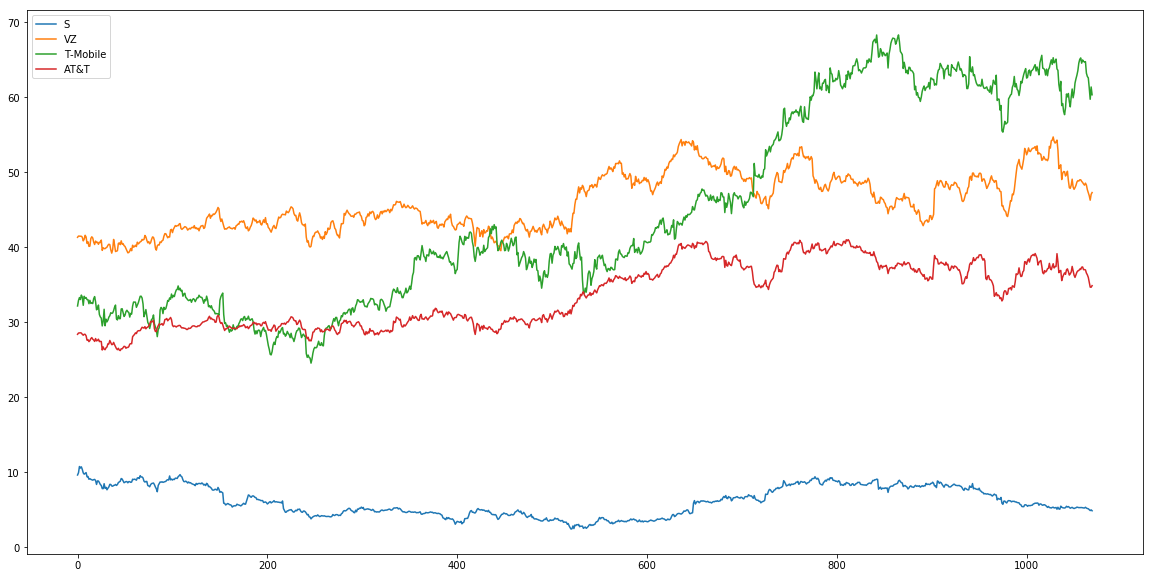

In [106]:
plt.figure(figsize=(20,10))
plt.plot(df_merge.S.values,  label="S")
plt.plot(df_merge.VZ.values,  label="VZ")
plt.plot(df_merge.TMUS.values ,  label="T-Mobile")
plt.plot(df_merge.T.values.tolist()[11] ,  label="AT&T")
plt.legend()

In [89]:
df_merge_Date_SadjClose_removed.head(2)

,0,1,2,3,4,5,6,7,8,9,T,TMUS,VZ,close_change,log_ret
0,0.205976,0.414829,0.280014,0.626173,0.049025,0.853566,0.478381,0.603496,1.0,0.000000,28.411475,32.19,41.341164,-0.002066,-0.002068
1,0.414829,0.280014,0.626173,0.049025,0.853566,0.478381,0.603496,1.000000,0.0,0.196189,28.582188,32.93,41.509973,0.031056,0.030583


## Input for AutoEncoders

In [276]:
df_merge_Date_SadjClose_removed.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'T', 'TMUS', 'VZ', 'close_change',
       'log_ret'],
      dtype='object')

In [277]:
df_merge_Date_SadjClose_removed.shape

(1070, 15)

In [278]:
len(YLabel)

1070

In [279]:
x_train =  df_merge_Date_SadjClose_removed.values

In [280]:
x_train.shape

(1070, 15)

In [281]:
window_length = len(df_merge_Date_SadjClose_removed.columns)
test_samples = int(x_train.shape[0]*0.1)
encoding_dim = 7
epochs = 100

In [282]:
print('test_samples',test_samples)

test_samples 107


In [283]:
x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## Simple feed-forward autoencoder

In [211]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 15)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 112       
_________________________________________________________________
dense_26 (Dense)             (None, 15)                120       
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


In [212]:
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=25,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Train on 963 samples, validate on 107 samples
Epoch 1/100
963/963 [==============================] - ETA: 17s - loss: 8.53 - 1s 602us/step - loss: -10.9386 - val_loss: -49.1922
Epoch 2/100
963/963 [==============================] - ETA: 0s - loss: -34.212 - 0s 55us/step - loss: -54.7867 - val_loss: -113.4016
Epoch 3/100
963/963 [==============================] - ETA: 0s - loss: -81.150 - 0s 52us/step - loss: -93.8053 - val_loss: -142.3293
Epoch 4/100
963/963 [==============================] - ETA: 0s - loss: -105.98 - 0s 54us/step - loss: -113.1222 - val_loss: -152.6782
Epoch 5/100
963/963 [==============================] - ETA: 0s - loss: -123.34 - 0s 55us/step - loss: -121.4139 - val_loss: -153.1238
Epoch 6/100
963/963 [==============================] - ETA: 0s - loss: -123.90 - 0s 50us/step - loss: -124.4916 - val_loss: -153.2940
Epoch 7/100
963/963 [==============================] - ETA: 0s - loss: -124.20 - 0s 51us/step - loss: -125.0219 - val_loss: -153.3574
Epoch 8/100
963/963 [

963/963 [==============================] - ETA: 0s - loss: -119.29 - 0s 49us/step - loss: -125.2575 - val_loss: -153.8267
Epoch 62/100
963/963 [==============================] - ETA: 0s - loss: -129.48 - 0s 48us/step - loss: -125.2578 - val_loss: -153.8282
Epoch 63/100
963/963 [==============================] - ETA: 0s - loss: -124.29 - 0s 51us/step - loss: -125.2579 - val_loss: -153.8279
Epoch 64/100
963/963 [==============================] - ETA: 0s - loss: -128.39 - 0s 50us/step - loss: -125.2578 - val_loss: -153.8290
Epoch 65/100
963/963 [==============================] - ETA: 0s - loss: -123.22 - 0s 49us/step - loss: -125.2583 - val_loss: -153.8284
Epoch 66/100
963/963 [==============================] - ETA: 0s - loss: -129.84 - 0s 49us/step - loss: -125.2577 - val_loss: -153.8282
Epoch 67/100
963/963 [==============================] - ETA: 0s - loss: -132.82 - 0s 48us/step - loss: -125.2581 - val_loss: -153.8291
Epoch 68/100
963/963 [==============================] - ETA: 0s - lo

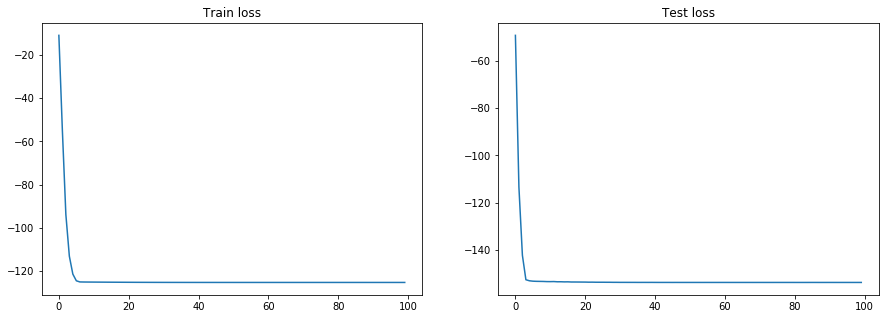

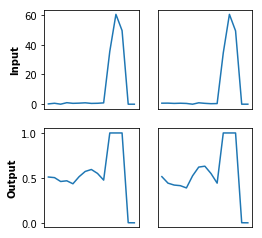

In [215]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [284]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=25,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 15)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 96        
_________________________________________________________________
batch_normalization_7 (Batch (None, 6)                 24        
_________________________________________________________________
dense_40 (Dense)             (None, 7)                 49        
_________________________________________________________________
dense_41 (Dense)             (None, 6)                 48        
_________________________________________________________________
batch_normalization_8 (Batch (None, 6)                 24        
_________________________________________________________________
dense_42 (Dense)             (None, 15)                105       
Total para

963/963 [==============================] - ETA: 0s - loss: -126.22 - ETA: 0s - loss: -125.12 - 0s 77us/step - loss: -125.2612 - val_loss: -153.8305
Epoch 45/100
963/963 [==============================] - ETA: 0s - loss: -126.13 - ETA: 0s - loss: -124.99 - 0s 72us/step - loss: -125.2613 - val_loss: -153.8305
Epoch 46/100
963/963 [==============================] - ETA: 0s - loss: -125.10 - ETA: 0s - loss: -125.03 - 0s 77us/step - loss: -125.2612 - val_loss: -153.8308
Epoch 47/100
963/963 [==============================] - ETA: 0s - loss: -128.87 - ETA: 0s - loss: -125.58 - 0s 74us/step - loss: -125.2612 - val_loss: -153.8309
Epoch 48/100
963/963 [==============================] - ETA: 0s - loss: -129.14 - ETA: 0s - loss: -125.08 - 0s 76us/step - loss: -125.2613 - val_loss: -153.8308
Epoch 49/100
963/963 [==============================] - ETA: 0s - loss: -130.31 - ETA: 0s - loss: -125.69 - 0s 74us/step - loss: -125.2614 - val_loss: -153.8307
Epoch 50/100
963/963 [=========================

Epoch 95/100
963/963 [==============================] - ETA: 0s - loss: -134.16 - ETA: 0s - loss: -126.19 - 0s 90us/step - loss: -125.2623 - val_loss: -153.8310
Epoch 96/100
963/963 [==============================] - ETA: 0s - loss: -130.84 - ETA: 0s - loss: -124.63 - 0s 82us/step - loss: -125.2620 - val_loss: -153.8310
Epoch 97/100
963/963 [==============================] - ETA: 0s - loss: -123.70 - ETA: 0s - loss: -124.87 - 0s 78us/step - loss: -125.2622 - val_loss: -153.8308
Epoch 98/100
963/963 [==============================] - ETA: 0s - loss: -133.50 - ETA: 0s - loss: -124.55 - 0s 81us/step - loss: -125.2622 - val_loss: -153.8308
Epoch 99/100
963/963 [==============================] - ETA: 0s - loss: -129.89 - ETA: 0s - loss: -125.70 - 0s 72us/step - loss: -125.2619 - val_loss: -153.8309
Epoch 100/100
963/963 [==============================] - ETA: 0s - loss: -120.05 - ETA: 0s - loss: -125.14 - 0s 75us/step - loss: -125.2625 - val_loss: -153.8308


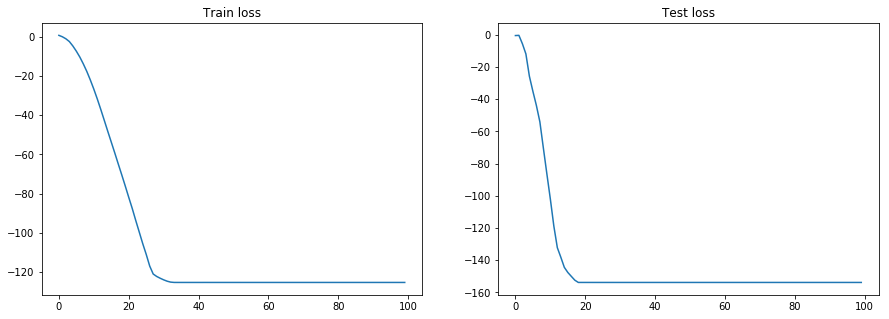

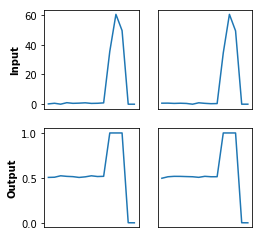

In [285]:
plot_history(history)
plot_examples(x_test_deep, decoded_stocks)

In [289]:
#Getting low dimension representation
_stocks = encoder.predict(x_test_deep)
print('original shape', x_test_deep.shape)
print('encoder o/p shape', _stocks.shape)


original shape (107, 15)
encoder o/p shape (107, 7)


## 1D Convolutional autoencoder

In [248]:
df_convo_df =  df_merge_Date_SadjClose_removed.copy()
df_convo_df["padded"]= 0

z_train =  df_convo_df.values

z_test = z_train[-test_samples:]
z_train = z_train[:-test_samples]

z_train = z_train.astype('float32')
z_test = z_test.astype('float32')

z_train = np.expand_dims(z_train, axis=0).reshape((963,16,1))
z_test = np.expand_dims(z_test, axis=0).reshape((107,16,1))

In [254]:
window_length = len(df_convo_df.columns)
test_samples = int(z_train.shape[0]*0.1)
encoding_dim = 7
epochs = 100

In [267]:

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 1, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(z_train, z_train,
                epochs=epochs,
                batch_size=10,
                shuffle=True,
                validation_data=(z_test, z_test))

decoded_stocks = autoencoder.predict(z_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 16, 1)             0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 16, 16)            64        
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 8, 1)              49        
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 4, 1)              0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 4, 1)              4         
_________________________________________________________________
up_sampling1d_33 (UpSampling (None, 8, 1)              0         
__________

963/963 [==============================] - ETA: 0s - loss: -116.57 - ETA: 0s - loss: -117.22 - ETA: 0s - loss: -117.48 - ETA: 0s - loss: -117.45 - ETA: 0s - loss: -117.23 - ETA: 0s - loss: -117.06 - 0s 384us/step - loss: -116.8639 - val_loss: -143.6164
Epoch 22/100
963/963 [==============================] - ETA: 1s - loss: -115.14 - ETA: 0s - loss: -117.00 - ETA: 0s - loss: -117.96 - ETA: 0s - loss: -116.47 - ETA: 0s - loss: -117.07 - ETA: 0s - loss: -117.11 - ETA: 0s - loss: -117.07 - ETA: 0s - loss: -117.00 - 0s 444us/step - loss: -116.8650 - val_loss: -143.6174
Epoch 23/100
963/963 [==============================] - ETA: 0s - loss: -106.22 - ETA: 0s - loss: -115.03 - ETA: 0s - loss: -117.51 - ETA: 0s - loss: -117.29 - ETA: 0s - loss: -117.14 - ETA: 0s - loss: -117.05 - ETA: 0s - loss: -116.71 - ETA: 0s - loss: -116.77 - 0s 424us/step - loss: -116.8661 - val_loss: -143.6189
Epoch 24/100
963/963 [==============================] - ETA: 0s - loss: -110.15 - ETA: 0s - loss: -116.44 - ETA

963/963 [==============================] - ETA: 0s - loss: -116.60 - ETA: 0s - loss: -118.05 - ETA: 0s - loss: -116.98 - ETA: 0s - loss: -115.30 - ETA: 0s - loss: -116.09 - ETA: 0s - loss: -116.68 - ETA: 0s - loss: -116.66 - ETA: 0s - loss: -116.47 - ETA: 0s - loss: -116.87 - 0s 472us/step - loss: -116.9043 - val_loss: -143.6584
Epoch 48/100
963/963 [==============================] - ETA: 0s - loss: -112.08 - ETA: 0s - loss: -117.63 - ETA: 0s - loss: -116.38 - ETA: 0s - loss: -116.08 - ETA: 0s - loss: -116.85 - ETA: 0s - loss: -116.73 - ETA: 0s - loss: -117.09 - 0s 393us/step - loss: -116.9063 - val_loss: -143.6592
Epoch 49/100
963/963 [==============================] - ETA: 0s - loss: -107.67 - ETA: 0s - loss: -113.47 - ETA: 0s - loss: -114.93 - ETA: 0s - loss: -115.45 - ETA: 0s - loss: -116.18 - ETA: 0s - loss: -116.82 - ETA: 0s - loss: -116.41 - ETA: 0s - loss: -117.04 - ETA: 0s - loss: -117.02 - 0s 470us/step - loss: -116.9084 - val_loss: -143.6613
Epoch 50/100
963/963 [===========

963/963 [==============================] - ETA: 0s - loss: -116.85 - ETA: 0s - loss: -116.12 - ETA: 0s - loss: -115.78 - ETA: 0s - loss: -115.52 - ETA: 0s - loss: -115.72 - ETA: 0s - loss: -116.38 - ETA: 0s - loss: -117.06 - 0s 388us/step - loss: -116.9581 - val_loss: -143.7126
Epoch 74/100
963/963 [==============================] - ETA: 0s - loss: -109.96 - ETA: 0s - loss: -115.33 - ETA: 0s - loss: -115.76 - ETA: 0s - loss: -115.64 - ETA: 0s - loss: -116.49 - ETA: 0s - loss: -116.84 - 0s 373us/step - loss: -116.9603 - val_loss: -143.7145
Epoch 75/100
963/963 [==============================] - ETA: 0s - loss: -106.60 - ETA: 0s - loss: -118.28 - ETA: 0s - loss: -118.00 - ETA: 0s - loss: -117.34 - ETA: 0s - loss: -117.03 - ETA: 0s - loss: -117.04 - ETA: 0s - loss: -117.07 - 0s 400us/step - loss: -116.9620 - val_loss: -143.7170
Epoch 76/100
963/963 [==============================] - ETA: 0s - loss: -117.40 - ETA: 0s - loss: -115.53 - ETA: 0s - loss: -116.46 - ETA: 0s - loss: -116.83 - ETA

963/963 [==============================] - ETA: 0s - loss: -108.37 - ETA: 0s - loss: -114.38 - ETA: 0s - loss: -115.56 - ETA: 0s - loss: -115.74 - ETA: 0s - loss: -116.14 - ETA: 0s - loss: -116.76 - 0s 376us/step - loss: -116.9877 - val_loss: -143.7413
Epoch 100/100
963/963 [==============================] - ETA: 0s - loss: -125.61 - ETA: 0s - loss: -118.09 - ETA: 0s - loss: -115.95 - ETA: 0s - loss: -116.63 - ETA: 0s - loss: -116.46 - ETA: 0s - loss: -116.72 - ETA: 0s - loss: -116.93 - ETA: 0s - loss: -116.95 - 0s 414us/step - loss: -116.9880 - val_loss: -143.7433


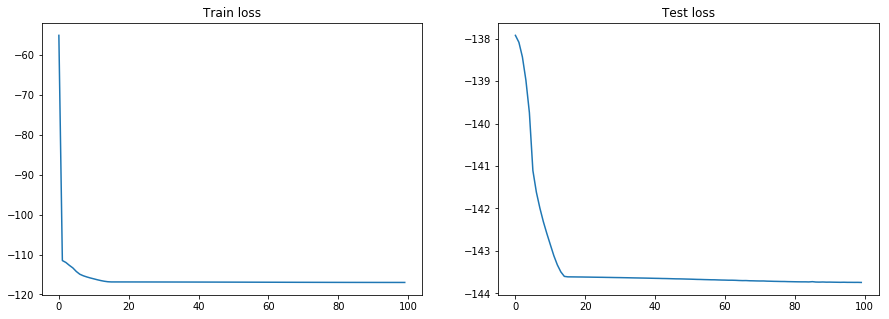

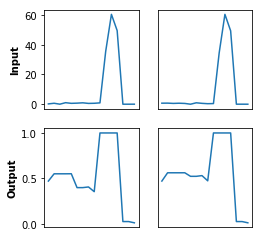

In [268]:
plot_history(history)
plot_examples(z_test, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

In [274]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(z_train, z_train,
                epochs=epochs,
                batch_size=15,
                shuffle=True,
                validation_data=(z_test, z_test))

decoded_stocks = sequence_autoencoder.predict(z_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 16, 1)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7)                 252       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 16, 7)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 16, 1)             36        
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________
Train on 963 samples, validate on 107 samples
Epoch 1/100
963/963 [==============================] - ETA: 2:15 - loss: 10.94 - ETA: 25s - loss: 10.0410 - ETA: 12s - loss: 8.620 - ETA: 7s - loss: 7.4167 - ETA: 5s - loss: 6.472 - ETA: 3s - loss: 5.660 - ETA: 2s - loss: 4.959 - 

Epoch 17/100
963/963 [==============================] - ETA: 0s - loss: -114.22 - ETA: 0s - loss: -114.94 - ETA: 0s - loss: -111.91 - ETA: 0s - loss: -110.86 - ETA: 0s - loss: -110.68 - ETA: 0s - loss: -111.29 - ETA: 0s - loss: -111.57 - ETA: 0s - loss: -111.40 - ETA: 0s - loss: -111.38 - ETA: 0s - loss: -111.72 - ETA: 0s - loss: -111.71 - ETA: 0s - loss: -111.94 - ETA: 0s - loss: -111.95 - ETA: 0s - loss: -112.28 - 1s 780us/step - loss: -112.2991 - val_loss: -138.9646
Epoch 18/100
963/963 [==============================] - ETA: 0s - loss: -114.40 - ETA: 0s - loss: -112.02 - ETA: 0s - loss: -113.31 - ETA: 0s - loss: -112.51 - ETA: 0s - loss: -112.57 - ETA: 0s - loss: -112.22 - ETA: 0s - loss: -111.79 - ETA: 0s - loss: -111.51 - ETA: 0s - loss: -111.89 - ETA: 0s - loss: -112.02 - ETA: 0s - loss: -112.21 - ETA: 0s - loss: -112.22 - ETA: 0s - loss: -112.41 - 1s 756us/step - loss: -112.3105 - val_loss: -138.9322
Epoch 19/100
963/963 [==============================] - ETA: 0s - loss: -107.0

Epoch 35/100
963/963 [==============================] - ETA: 0s - loss: -112.02 - ETA: 0s - loss: -111.33 - ETA: 0s - loss: -111.34 - ETA: 0s - loss: -111.75 - ETA: 0s - loss: -111.81 - ETA: 0s - loss: -111.13 - ETA: 0s - loss: -111.79 - ETA: 0s - loss: -111.66 - ETA: 0s - loss: -112.28 - ETA: 0s - loss: -112.59 - ETA: 0s - loss: -112.57 - ETA: 0s - loss: -112.54 - ETA: 0s - loss: -112.38 - 1s 769us/step - loss: -112.3059 - val_loss: -138.9625
Epoch 36/100
963/963 [==============================] - ETA: 0s - loss: -111.09 - ETA: 0s - loss: -112.28 - ETA: 0s - loss: -112.03 - ETA: 0s - loss: -111.57 - ETA: 0s - loss: -111.24 - ETA: 0s - loss: -111.22 - ETA: 0s - loss: -111.62 - ETA: 0s - loss: -112.03 - ETA: 0s - loss: -112.01 - ETA: 0s - loss: -112.10 - ETA: 0s - loss: -112.19 - ETA: 0s - loss: -112.35 - ETA: 0s - loss: -112.35 - 1s 760us/step - loss: -112.3105 - val_loss: -138.9759
Epoch 37/100
963/963 [==============================] - ETA: 0s - loss: -112.50 - ETA: 0s - loss: -109.8

963/963 [==============================] - ETA: 0s - loss: -115.55 - ETA: 0s - loss: -109.74 - ETA: 0s - loss: -108.62 - ETA: 0s - loss: -111.12 - ETA: 0s - loss: -111.51 - ETA: 0s - loss: -111.23 - ETA: 0s - loss: -111.67 - ETA: 0s - loss: -111.44 - ETA: 0s - loss: -111.67 - ETA: 0s - loss: -111.82 - ETA: 0s - loss: -112.03 - ETA: 0s - loss: -112.08 - ETA: 0s - loss: -112.09 - 1s 769us/step - loss: -112.3232 - val_loss: -139.0046
Epoch 54/100
963/963 [==============================] - ETA: 0s - loss: -123.71 - ETA: 0s - loss: -113.19 - ETA: 0s - loss: -113.22 - ETA: 0s - loss: -113.20 - ETA: 0s - loss: -113.47 - ETA: 0s - loss: -113.59 - ETA: 0s - loss: -113.18 - ETA: 0s - loss: -113.16 - ETA: 0s - loss: -112.88 - ETA: 0s - loss: -112.59 - ETA: 0s - loss: -112.35 - ETA: 0s - loss: -112.22 - ETA: 0s - loss: -112.47 - 1s 765us/step - loss: -112.3274 - val_loss: -139.0076
Epoch 55/100
963/963 [==============================] - ETA: 0s - loss: -113.75 - ETA: 0s - loss: -112.46 - ETA: 0s -

Epoch 71/100
963/963 [==============================] - ETA: 0s - loss: -113.71 - ETA: 0s - loss: -112.71 - ETA: 0s - loss: -113.25 - ETA: 0s - loss: -113.61 - ETA: 0s - loss: -112.56 - ETA: 0s - loss: -112.91 - ETA: 0s - loss: -112.54 - ETA: 0s - loss: -112.22 - ETA: 0s - loss: -112.59 - ETA: 0s - loss: -112.43 - ETA: 0s - loss: -112.09 - ETA: 0s - loss: -112.02 - ETA: 0s - loss: -112.22 - ETA: 0s - loss: -112.22 - 1s 841us/step - loss: -112.3898 - val_loss: -139.1011
Epoch 72/100
963/963 [==============================] - ETA: 0s - loss: -114.88 - ETA: 0s - loss: -111.61 - ETA: 0s - loss: -112.82 - ETA: 0s - loss: -113.34 - ETA: 0s - loss: -112.83 - ETA: 0s - loss: -113.27 - ETA: 0s - loss: -112.87 - ETA: 0s - loss: -112.59 - ETA: 0s - loss: -112.69 - ETA: 0s - loss: -112.55 - ETA: 0s - loss: -112.69 - ETA: 0s - loss: -112.57 - ETA: 0s - loss: -112.46 - ETA: 0s - loss: -112.37 - 1s 845us/step - loss: -112.4010 - val_loss: -139.1089
Epoch 73/100
963/963 [==============================

963/963 [==============================] - ETA: 0s - loss: -111.68 - ETA: 0s - loss: -112.58 - ETA: 0s - loss: -110.92 - ETA: 0s - loss: -111.51 - ETA: 0s - loss: -111.62 - ETA: 0s - loss: -111.76 - ETA: 0s - loss: -112.70 - ETA: 0s - loss: -112.03 - ETA: 0s - loss: -112.12 - ETA: 0s - loss: -112.44 - ETA: 0s - loss: -112.76 - ETA: 0s - loss: -112.54 - ETA: 0s - loss: -112.55 - ETA: 0s - loss: -112.23 - ETA: 0s - loss: -112.30 - 1s 878us/step - loss: -112.4645 - val_loss: -139.1983
Epoch 88/100
963/963 [==============================] - ETA: 0s - loss: -112.03 - ETA: 0s - loss: -112.61 - ETA: 0s - loss: -111.23 - ETA: 0s - loss: -111.60 - ETA: 0s - loss: -111.97 - ETA: 0s - loss: -112.10 - ETA: 0s - loss: -111.74 - ETA: 0s - loss: -111.87 - ETA: 0s - loss: -111.56 - ETA: 0s - loss: -112.16 - ETA: 0s - loss: -112.49 - ETA: 0s - loss: -112.62 - ETA: 0s - loss: -112.37 - ETA: 0s - loss: -112.43 - 1s 843us/step - loss: -112.4829 - val_loss: -139.0847
Epoch 89/100
963/963 [=================

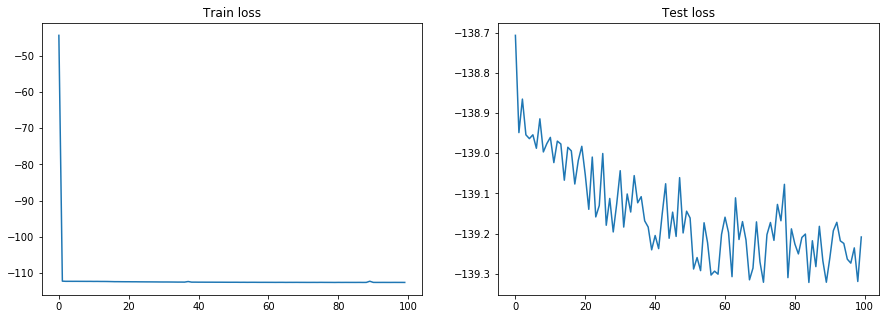

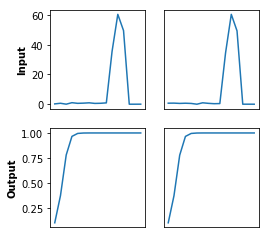

In [273]:
plot_history(history)
plot_examples(z_test, decoded_stocks)